## Overview

Neural style transfer is an optimization technique used to take three images, a **content** image, a **style reference** image (such as an artwork by a famous painter), and the **input** image you want to style -- and blend them together such that the input image is transformed to look like the content image, but “painted” in the style of the style image.


For example, let’s take an image of this turtle and Katsushika Hokusai's *The Great Wave off Kanagawa*:

<img src="https://github.com/tensorflow/models/blob/master/research/nst_blogpost/Green_Sea_Turtle_grazing_seagrass.jpg?raw=1" alt="Drawing" style="width: 200px;"/>
<img src="https://github.com/tensorflow/models/blob/master/research/nst_blogpost/The_Great_Wave_off_Kanagawa.jpg?raw=1" alt="Drawing" style="width: 200px;"/>

[Image of Green Sea Turtle](https://commons.wikimedia.org/wiki/File:Green_Sea_Turtle_grazing_seagrass.jpg)
-By P.Lindgren [CC BY-SA 3.0  (https://creativecommons.org/licenses/by-sa/3.0)], from Wikimedia Commons


Now how would it look like if Hokusai decided to paint the picture of this Turtle exclusively with this style? Something like this?

<img src="https://github.com/tensorflow/models/blob/master/research/nst_blogpost/wave_turtle.png?raw=1" alt="Drawing" style="width: 500px;"/>

Is this magic or just deep learning? Fortunately, this doesn’t involve any witchcraft: style transfer is a fun and interesting technique that showcases the capabilities and internal representations of neural networks.  

The principle of neural style transfer is to define two distance functions, one that describes how different the content of two images are , $L_{content}$, and one that describes the difference between two images in terms of their style, $L_{style}$. Then, given three images, a desired style image, a desired content image, and the input image (initialized with the content image), we try to transform the input image to minimize the content distance with the content image and its style distance with the style image. 
In summary, we’ll take the base input image, a content image that we want to match, and the style image that we want to match. We’ll transform the base input image by minimizing the content and style distances (losses) with backpropagation, creating an image that matches the content of the content image and the style of the style image. 

### Preparing Google Colab

In [29]:
from google.colab import drive
import os
import tensorflow as tf 

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))


drive.mount('/content/gdrive/')

%cd /content/gdrive/MyDrive/Colab Notebooks/


Found GPU at: /device:GPU:0
Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).
/content/gdrive/MyDrive/Colab Notebooks


### Loading Libraries and data

As always, the first thing we have to do is load the packages and the data that we are going to use. Regarding packages, we will use Keras and Tensorflow for neural networks and Numpy for data manipulation.

In [30]:
import numpy as np
from tensorflow.keras.utils import get_file
import matplotlib.pyplot as plt
from tensorflow.keras.applications import vgg19
from tensorflow.keras.preprocessing.image import load_img,save_img,img_to_array
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras import Model
from datetime import datetime

In [44]:
style_transfer_url = "https://i.imgur.com/9ooB60I.jpg"
style_image_path = get_file(fname = "skyscraper.jpg", origin = style_transfer_url)

#style_transfer_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/2/2e/Shipwreck_turner.jpg/1200px-Shipwreck_turner.jpg?20160912144312"
#style_image_path = get_file(fname = "Shipwreck_of_the_Minotaur_William_Turner.jpg", origin = style_transfer_url)

#style_transfer_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/8/86/Edvard_Munch_-_The_Scream_-_Google_Art_Project.jpg/450px-Edvard_Munch_-_The_Scream_-_Google_Art_Project.jpg"
#style_image_path = get_file(fname = "450px-Edvard_Munch_-_The_Scream_-_Google_Art_Project.jpg",origin = style_transfer_url)


base_url = "https://upload.wikimedia.org/wikipedia/commons/0/00/Tuebingen_Neckarfront.jpg"
base_image_path = get_file(fname = "Tuebingen_Neckarfront.jpg", origin = base_url)

### Visualize input image

We are going to visualize the images that we have downloaded and that we are going to use for the Neural Style Transfer

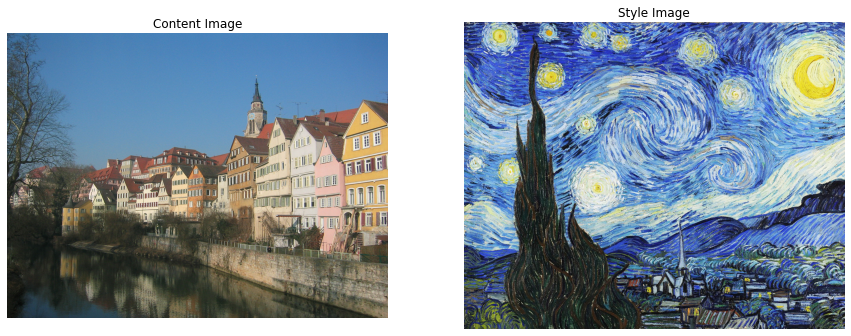

In [48]:
# read the image file in a numpy array
a = plt.imread(base_image_path)
b = plt.imread(style_image_path)
fig, ax = plt.subplots(1,2, figsize=(15,15))
ax[0].imshow(a)
ax[1].imshow(b)
ax[0].set_title('Content Image')
ax[1].set_title('Style Image')
ax[0].axis('off')
ax[1].axis('off')
plt.show()


## Build the Model 
In this case, we load [VGG19](https://keras.io/applications/#vgg19), and feed in our input tensor to the model. This will allow us to extract the feature maps (and subsequently the content and style representations) of the content, style, and generated images.

We use VGG19, as suggested in the paper. In addition, since VGG19 is a relatively simple model (compared with ResNet, Inception, etc) the feature maps actually work better for style transfer

In order to access the intermediate layers corresponding to our style and content feature maps, we get the corresponding outputs and using the Keras [**Functional API**](https://keras.io/getting-started/functional-api-guide/), we define our model with the desired output activations. 

With the Functional API defining a model simply involves defining the input and output: 

`model = Model(inputs, outputs)`

In [33]:
model = vgg19.VGG19(weights="imagenet", include_top=False)
outputs_dict= dict([(layer.name, layer.output) for layer in model.layers])
feature_extractor = Model(inputs=model.inputs, outputs=outputs_dict)
model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

### Define content and style representations
In order to get both the content and style representations of our image, we will look at some intermediate layers within our model. As we go deeper into the model, these intermediate layers represent higher and higher order features. In this case, we are using the network architecture VGG19, a pretrained image classification network. These intermediate layers are necessary to define the representation of content and style from our images. For an input image, we will try to match the corresponding style and content target representations at these intermediate layers. 

#### Why intermediate layers?

You may be wondering why these intermediate outputs within our pretrained image classification network allow us to define style and content representations. At a high level, this phenomenon can be explained by the fact that in order for a network to perform image classification (which our network has been trained to do), it must understand the image. This involves taking the raw image as input pixels and building an internal representation through transformations that turn the raw image pixels into a complex understanding of the features present within the image. This is also partly why convolutional neural networks are able to generalize well: they’re able to capture the invariances and defining features within classes (e.g., cats vs. dogs) that are agnostic to background noise and other nuisances. Thus, somewhere between where the raw image is fed in and the classification label is output, the model serves as a complex feature extractor; hence by accessing intermediate layers, we’re able to describe the content and style of input images. 


Specifically we’ll pull out these intermediate layers from our network: 

In [34]:
style_layers = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]

content_layers = "block5_conv2"

content_weight = 2.5e-8
style_weight = 1e-6

## Define and create our loss functions (content and style distances)

### Content Loss

Our content loss definition is actually quite simple. We’ll pass the network both the desired content image and our base input image. This will return the intermediate layer outputs (from the layers defined above) from our model. Then we simply take the euclidean distance between the two intermediate representations of those images.  

More formally, content loss is a function that describes the distance of content from our output image $x$ and our content image, $p$. Let $C_{nn}$ be a pre-trained deep convolutional neural network. Again, in this case we use [VGG19](https://keras.io/applications/#vgg19). Let $X$ be any image, then $C_{nn}(X)$ is the network fed by X. Let $F^l_{ij}(x) \in C_{nn}(x)$ and $P^l_{ij}(p) \in C_{nn}(p)$ describe the respective intermediate feature representation of the network with inputs $x$ and $p$ at layer $l$. Then we describe the content distance (loss) formally as: $$L^l_{content}(p, x) = \sum_{i, j} (F^l_{ij}(x) - P^l_{ij}(p))^2$$

We perform backpropagation in the usual way such that we minimize this content loss. We thus change the initial image until it generates a similar response in a certain layer (defined in content_layer) as the original content image.

This can be implemented quite simply. Again it will take as input the feature maps at a layer L in a network fed by x, our input image, and p, our content image, and return the content distance.



In [35]:
def content_loss(base, combination):
  return tf.reduce_sum(tf.square(combination - base))

## Style Loss

Computing style loss is a bit more involved, but follows the same principle, this time feeding our network the base input image and the style image. However, instead of comparing the raw intermediate outputs of the base input image and the style image, we instead compare the Gram matrices of the two outputs. 

Mathematically, we describe the style loss of the base input image, $x$, and the style image, $a$, as the distance between the style representation (the gram matrices) of these images. We describe the style representation of an image as the correlation between different filter responses given by the Gram matrix  $G^l$, where $G^l_{ij}$ is the inner product between the vectorized feature map $i$ and $j$ in layer $l$. We can see that $G^l_{ij}$ generated over the feature map for a given image represents the correlation between feature maps $i$ and $j$. 

To generate a style for our base input image, we perform gradient descent from the content image to transform it into an image that matches the style representation of the original image. We do so by minimizing the mean squared distance between the feature correlation map of the style image and the input image. The contribution of each layer to the total style loss is described by
$$E_l = \frac{1}{4N_l^2M_l^2} \sum_{i,j}(G^l_{ij} - A^l_{ij})^2$$

where $G^l_{ij}$ and $A^l_{ij}$ are the respective style representation in layer $l$ of $x$ and $a$. $N_l$ describes the number of feature maps, each of size $M_l = height * width$. Thus, the total style loss across each layer is 
$$L_{style}(a, x) = \sum_{l \in L} w_l E_l$$
where we weight the contribution of each layer's loss by some factor $w_l$. In our case, we weight each layer equally ($w_l =\frac{1}{|L|}$)

In [36]:
def gram_matrix(x):
  x = tf.transpose(x, (2, 0, 1))
  features = tf.reshape(x, (tf.shape(x)[0], -1))
  gram = tf.matmul(features, tf.transpose(features))
  return gram

def style_loss(style, combination):
  S = gram_matrix(style)
  C = gram_matrix(combination)
  channels = 3
  size = n_rows * n_cols
  return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))


### Computing the loss and gradients
Here we use [**tf.GradientTape**](https://www.tensorflow.org/programmers_guide/eager#computing_gradients) to compute the gradient. It allows us to take advantage of the automatic differentiation available by tracing operations for computing the gradient later. It records the operations during the forward pass and then is able to compute the gradient of our loss function with respect to our input image for the backwards pass.

In [37]:
def loss_function(combination_image, base_image, style_reference_image):
  # 1. Combine all the images in the same tensor.
  input_tensor = tf.concat([base_image, style_reference_image, combination_image], axis=0)

  # 2. Get the values in all the layers for the three images.
  features = feature_extractor(input_tensor)

  #3. Initialize the loss
  loss = tf.zeros(shape=())

  # 4. Extract the content layers + content loss
  layer_features = features[content_layers]
  base_image_features = layer_features[0, :, :, :]
  combination_features = layer_features[2, :, :, :]

  loss = loss + content_weight * content_loss(base_image_features, combination_features)
  
  # 5. Extract the style layers + style loss
  for layer_name in style_layers:
    layer_features = features[layer_name]
    style_reference_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_reference_features, combination_features)
    loss += (style_weight / len(style_layers)) * sl

  return loss

In [38]:
@tf.function
def compute_loss_and_grads(combination_image, base_image, style_reference_image):
  with tf.GradientTape() as tape:
    loss = loss_function(combination_image, base_image, style_reference_image)
  grads = tape.gradient(loss, combination_image)
  return loss, grads

### Preprocessing Input Image

The preprocessing of the images consists of giving the images the format that our network requires. In the case of Keras, as it is the VGG19 model, the model itself has an image preprocessing function: preprocess_input.

Keep in mind that Keras works with image batches. Therefore, the information we pass on must be in this format. To do this, carry out the following processes:

* **load_image** : we upload an image and give it a specific shape.
* **img_to_array** : we convert the loaded image into an array that considers the number of channels. In our case, being color images, we will have three channels, while a black and white image would have only one channel.
* **expand_dims** : we group all the images in a single array, since, as we have said, Keras works with batches of images. Thus, the result of this step will be an array with shape (3, width, height, 3).
* **preprocess_input**: subtract the mean of the RGB values from the Imagenet dataset (with which VGG19 is trained), in such a way that we get the images to have zero average. This is a typical preprocessing in images, as this prevents gradients from being too “extreme”, thus achieving better model results (link).
* **convert_to_tensor**: finally, we are going to convert our already centered array into a data type that Tensorflow understands. For that, we will simply convert it to a tensor with this function

In [39]:
def preprocess_image(image_path):
  # Util function to open, resize and format pictures into appropriate tensors
  img = load_img(image_path, target_size=(n_rows, n_cols))
  img = img_to_array(img)
  img = np.expand_dims(img, axis=0)
  img = vgg19.preprocess_input(img)
  return tf.convert_to_tensor(img)

### Deprocessing Output Image

To deprocess the images we will have to follow an almost reverse process to the one we have used to process the images. For this we will carry out the following steps:

* Convert the tensor into an array that we can use.
* Make the data not have a zero average. To do this, we must add the average for each of the channels of the Imagenet dataset. Luckily this is not something that has to be calculated, since we can find it here. Also, we make sure that there are no values above 255 or below 0.
* Convert images from BGR to RGB. This is due to the fact that historically the use of the BGR format has become popular and that is why packages like OpenCV read images as BGR instead of RGB.

In [40]:
def deprocess_image(x):
  # Convert tensor to Array
  x = x.reshape((n_rows, n_cols, 3))

  x[:, :, 0] += 103.939
  x[:, :, 1] += 116.779
  x[:, :, 2] += 123.68

  #We convert from BGR to RGB.
  x = x[:, :, ::-1]

  # We make sure the values are between 0 and 255
  x = np.clip(x, 0, 255).astype("uint8")

  return x

### Save the generated images

We are going to create is a simple function that saves the generated image

In [41]:
def result_saver(iteration):
  # Create name
  now = datetime.now()
  now = now.strftime("%Y%m%d_%H%M%S")
  image_name = str(i) + '_' + str(now)+"_image" + '.png'

  # Save image
  img = deprocess_image(combination_image.numpy())
  save_img(image_name, img)

### Run Gradient Descent

Now that we have all the ingredients already created, creating the training loop is quite simple. You simply have to:

* Preprocess images and create the combined image,
* Iteratively, calculate loss, and apply the gradients to the combined image.
* Every few iterations, show the error and save the generated image and the model. In my case, since I am training the network in Google Colab, saving the images is essential, since otherwise we risk being disconnected from the server during the training process and have to start over from scratch.

 If you aren't familiar with gradient descent/backpropagation or need a refresher, you should definitely check out this [awesome resource](https://developers.google.com/machine-learning/crash-course/reducing-loss/gradient-descent).

In this case, we use the [SGD](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/SGD)* optimizer in order to minimize our loss. We iteratively update our output image such that it minimizes our loss: we don't update the weights associated with our network, but instead we train our input image to minimize loss.

![figure](https://user-images.githubusercontent.com/30661597/107026142-96fa0100-67aa-11eb-9f71-4adce01dd362.png)

In [42]:
width, height = load_img(base_image_path).size
n_rows = 400
n_cols = int(width * n_rows / height)

optimizer = SGD(ExponentialDecay(initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96))

base_image = preprocess_image(base_image_path)
style_reference_image = preprocess_image(style_image_path)
combination_image = tf.Variable(preprocess_image(base_image_path))

iterations = 10000

for i in range(1, iterations + 1):
    print("Running Iteration : {0}".format(i))
    loss, grads = compute_loss_and_grads(
        combination_image, base_image, style_reference_image
    )
    optimizer.apply_gradients([(grads, combination_image)])
    if i % 10000 == 0:
        print("Iteration %d: loss=%.2f" % (i, loss))
        result_saver(i)

Streaming output truncated to the last 5000 lines.
Running Iteration : 5002
Running Iteration : 5003
Running Iteration : 5004
Running Iteration : 5005
Running Iteration : 5006
Running Iteration : 5007
Running Iteration : 5008
Running Iteration : 5009
Running Iteration : 5010
Running Iteration : 5011
Running Iteration : 5012
Running Iteration : 5013
Running Iteration : 5014
Running Iteration : 5015
Running Iteration : 5016
Running Iteration : 5017
Running Iteration : 5018
Running Iteration : 5019
Running Iteration : 5020
Running Iteration : 5021
Running Iteration : 5022
Running Iteration : 5023
Running Iteration : 5024
Running Iteration : 5025
Running Iteration : 5026
Running Iteration : 5027
Running Iteration : 5028
Running Iteration : 5029
Running Iteration : 5030
Running Iteration : 5031
Running Iteration : 5032
Running Iteration : 5033
Running Iteration : 5034
Running Iteration : 5035
Running Iteration : 5036
Running Iteration : 5037
Running Iteration : 5038
Running Iteration : 5039

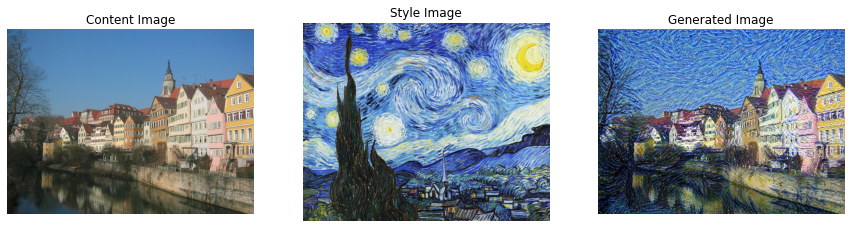

In [47]:
## Visualizing the generated image
a = plt.imread(base_image_path)
b = plt.imread(style_image_path)
c = plt.imread("Generated Image.png")
fig, ax = plt.subplots(1,3, figsize=(15,15))
ax[0].imshow(a)
ax[1].imshow(b)
ax[2].imshow(c)
ax[0].set_title('Content Image')
ax[1].set_title('Style Image')
ax[2].set_title('Generated Image')
ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')
plt.show()